In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage import io

from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# SQL Part

In [3]:
dbname = '/Volumes/External/dataset/Book-Recommendation/book.sqlite'
connection_string = f"sqlite:///{dbname}"

In [4]:
# init load extension
%load_ext sql

In [5]:
%sql $connection_string

In [6]:
%%sql
select *
    from sqlite_master
    where type = 'table'; 

 * sqlite:////Volumes/External/dataset/Book-Recommendation/book.sqlite
Done.


type,name,tbl_name,rootpage,sql
table,BX-Books,BX-Books,2,"CREATE TABLE `BX-Books` ( `ISBN` TEXT NOT NULL default '', `Book-Title` TEXT default NULL, `Book-Author` TEXT default NULL, `Year-Of-Publication` INTEGER default NULL, `Publisher` TEXT default NULL, `Image-URL-S` TEXT default NULL, `Image-URL-M` TEXT default NULL, `Image-URL-L` TEXT default NULL, PRIMARY KEY (`ISBN`))"
table,BX-Users,BX-Users,20612,"CREATE TABLE `BX-Users` ( `User-ID` INTEGER NOT NULL default '0', `Location` TEXT default NULL, `Age` INTEGER default NULL, PRIMARY KEY (`User-ID`))"
table,BX-Book-Ratings,BX-Book-Ratings,23160,"CREATE TABLE `BX-Book-Ratings` ( `User-ID` INTEGER NOT NULL default '0', `ISBN` TEXT NOT NULL default '', `Book-Rating` INTEGER NOT NULL default '0', PRIMARY KEY (`User-ID`,`ISBN`))"


In [7]:
%%sql
select `ISBN`, `Book-Title`, `Book-Author`, `Year-Of-Publication`, `Publisher`
    from 'BX-Books' 
    limit 5;

 * sqlite:////Volumes/External/dataset/Book-Recommendation/book.sqlite
Done.


ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [8]:
%%sql
select *
    from 'BX-Users'
    limit 5;

 * sqlite:////Volumes/External/dataset/Book-Recommendation/book.sqlite
Done.


User-ID,Location,Age
1,"nyc, new york, usa",None
2,"stockton, california, usa",18
3,"moscow, yukon territory, russia",None
4,"porto, v.n.gaia, portugal",17
5,"farnborough, hants, united kingdom",None


In [9]:
%%sql
select *
    from 'BX-Book-Ratings'
    limit 5;

 * sqlite:////Volumes/External/dataset/Book-Recommendation/book.sqlite
Done.


User-ID,ISBN,Book-Rating
276725,034545104X,0
276726,0155061224,5
276727,0446520802,0
276729,052165615X,3
276729,0521795028,6


## SQL get data to dataframe

In [10]:
%%sql rs << 
select `ISBN`, `Book-Title`, `Book-Author`, `Year-Of-Publication`, `Publisher`, `Image-URL-M`
    from 'BX-Books';

 * sqlite:////Volumes/External/dataset/Book-Recommendation/book.sqlite
Done.
Returning data to local variable rs


In [11]:
df_bx_book = rs.DataFrame()

In [12]:
%%sql rs <<
select *
    from 'BX-Users'

 * sqlite:////Volumes/External/dataset/Book-Recommendation/book.sqlite
Done.
Returning data to local variable rs


In [13]:
df_bx_user = rs.DataFrame()

In [14]:
%%sql rs <<
select *
    from 'BX-Book-Ratings';

 * sqlite:////Volumes/External/dataset/Book-Recommendation/book.sqlite
Done.
Returning data to local variable rs


In [15]:
df_bx_rating = rs.DataFrame()

# Data preprocess

## Data exploration

In [16]:
df_bx_user.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [17]:
df_bx_user.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

In [18]:
df_bx_book.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...


In [19]:
df_bx_book.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-M            0
dtype: int64

In [20]:
df_bx_rating.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [21]:
df_bx_rating.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

## Init dataframe

In [22]:
# rename columns
df_bx_book.rename(columns={'Book-Title':'title', 'Book-Author':'author', 'Year-Of-Publication':'year', 'Publisher':'publisher', 'Image-URL-M':'url'}, inplace=True)
df_bx_user.rename(columns={'User-ID':'user_id', 'Location':'location', 'Age':'age'}, inplace=True)
df_bx_rating.rename(columns={'User-ID':'user_id', 'Book-Rating':'rating'}, inplace=True)

In [23]:
rating_book = df_bx_rating.merge(df_bx_book, on='ISBN')
rating_book.head()

,user_id,ISBN,rating,title,author,year,publisher,url
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...


In [24]:
# find a number of ratings for each book
num_rating = rating_book[['title', 'rating']].groupby(['title']).count().reset_index()
num_rating.rename(columns={'rating':'num_of_rating'}, inplace=True)

# find average of rating for each book 
avg_rating = rating_book[['title', 'rating']].groupby(['title']).mean().reset_index()
avg_rating.rename(columns={'rating':'avg_of_rating'}, inplace=True)

In [25]:
# filters only books with a number of ratings greater than 20 times.
final_rating_book = rating_book.merge(num_rating, on='title')
final_rating_book = final_rating_book.merge(avg_rating, on='title')

In [26]:
final_rating_book.shape

(1031175, 10)

In [27]:
final_rating_book['num_of_rating'].quantile(0.60)

23.0

In [28]:
final_rating_book = final_rating_book[final_rating_book['num_of_rating'] >= 50]
final_rating_book.drop_duplicates(['title'], inplace=True)
final_rating_book.reset_index(drop=True, inplace=True)

In [29]:
# create text feture from 3 columns: 1) title, 2) author, and 3) publisher
final_rating_book['feature'] = final_rating_book[['title', 'author', 'publisher']].apply(lambda row: f"{row['title']} {row['author']} {row['publisher']}", axis=1)
final_rating_book.head()

,user_id,ISBN,rating,title,author,year,publisher,url,num_of_rating,avg_of_rating,feature
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,60,2.933333,Flesh Tones: A Novel M. J. Rose Ballantine Books
1,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,650,3.560000,The Notebook Nicholas Sparks Warner Books
2,276744,038550120X,7,A Painted House,JOHN GRISHAM,2001,Doubleday,http://images.amazon.com/images/P/038550120X.0...,838,3.231504,A Painted House JOHN GRISHAM Doubleday
3,276746,0425115801,0,Lightning,Dean R. Koontz,1996,Berkley Publishing Group,http://images.amazon.com/images/P/0425115801.0...,274,2.627737,Lightning Dean R. Koontz Berkley Publishing Group
4,276746,0449006522,0,Manhattan Hunt Club,JOHN SAUL,2002,Ballantine Books,http://images.amazon.com/images/P/0449006522.0...,111,3.504505,Manhattan Hunt Club JOHN SAUL Ballantine Books


In [30]:
final_rating_book.shape

(2444, 11)

# Buid book recommendation 

## Using CountVectorize (NLP technique) and cosine similarity

In [31]:
count_matrix = CountVectorizer().fit_transform(final_rating_book['feature'])
cos_sim = cosine_similarity(count_matrix)

In [32]:
dict_features = {}
for i in range(len(final_rating_book)):
    tmp = {}
    tmp['text'] = cos_sim[i]
    tmp['avg'] = final_rating_book['avg_of_rating'][i]
    dict_features[i] = tmp

In [33]:
def transform(obj):
    tmp = np.append(obj['text'], obj['avg'])
    return tmp

In [34]:
X = []
for i in range(len(final_rating_book)):
    X.append(transform(dict_features[i]))

## Recommend

In [39]:
model = NearestNeighbors().fit(X)

In [40]:
def get_recommend(model, dict_feat, n):
    _, suggestions = model.kneighbors([transform(dict_feat)], n_neighbors=n)
    return suggestions[0]

In [41]:
# Get book recommend
def book_recommend(model, title, show=True):
    # get index from book title
    book_id = final_rating_book[final_rating_book['title'] == title].index.values.astype(int)[0]

    # generate and sort recommend score
    suggestions = get_recommend(model, dict_features[book_id], 11)

    result = {}
    for idx, item in enumerate(suggestions):
        tmp = {}
        tmp['order'] = idx
        tmp['title'] = final_rating_book['title'][item]
        tmp['url'] = final_rating_book['url'][item]
        result[idx] = tmp

    if show:
        plt.figure(1, figsize=(20, 50))
        for item in result:
            if item == 0:
                plt.subplot(6, 2, item+1)
                plt.imshow(io.imread(result[item]['url']))
                plt.xlabel(f"{result[item]['title']}")
                plt.title(f"USER SELECT")
            else:
                plt.subplot(6, 2, item+2)
                plt.imshow(io.imread(result[item]['url']))
                plt.xlabel(f"{result[item]['title']}")
                plt.title(f"Recommend {result[item]['order']}")
        plt.show()

    return result

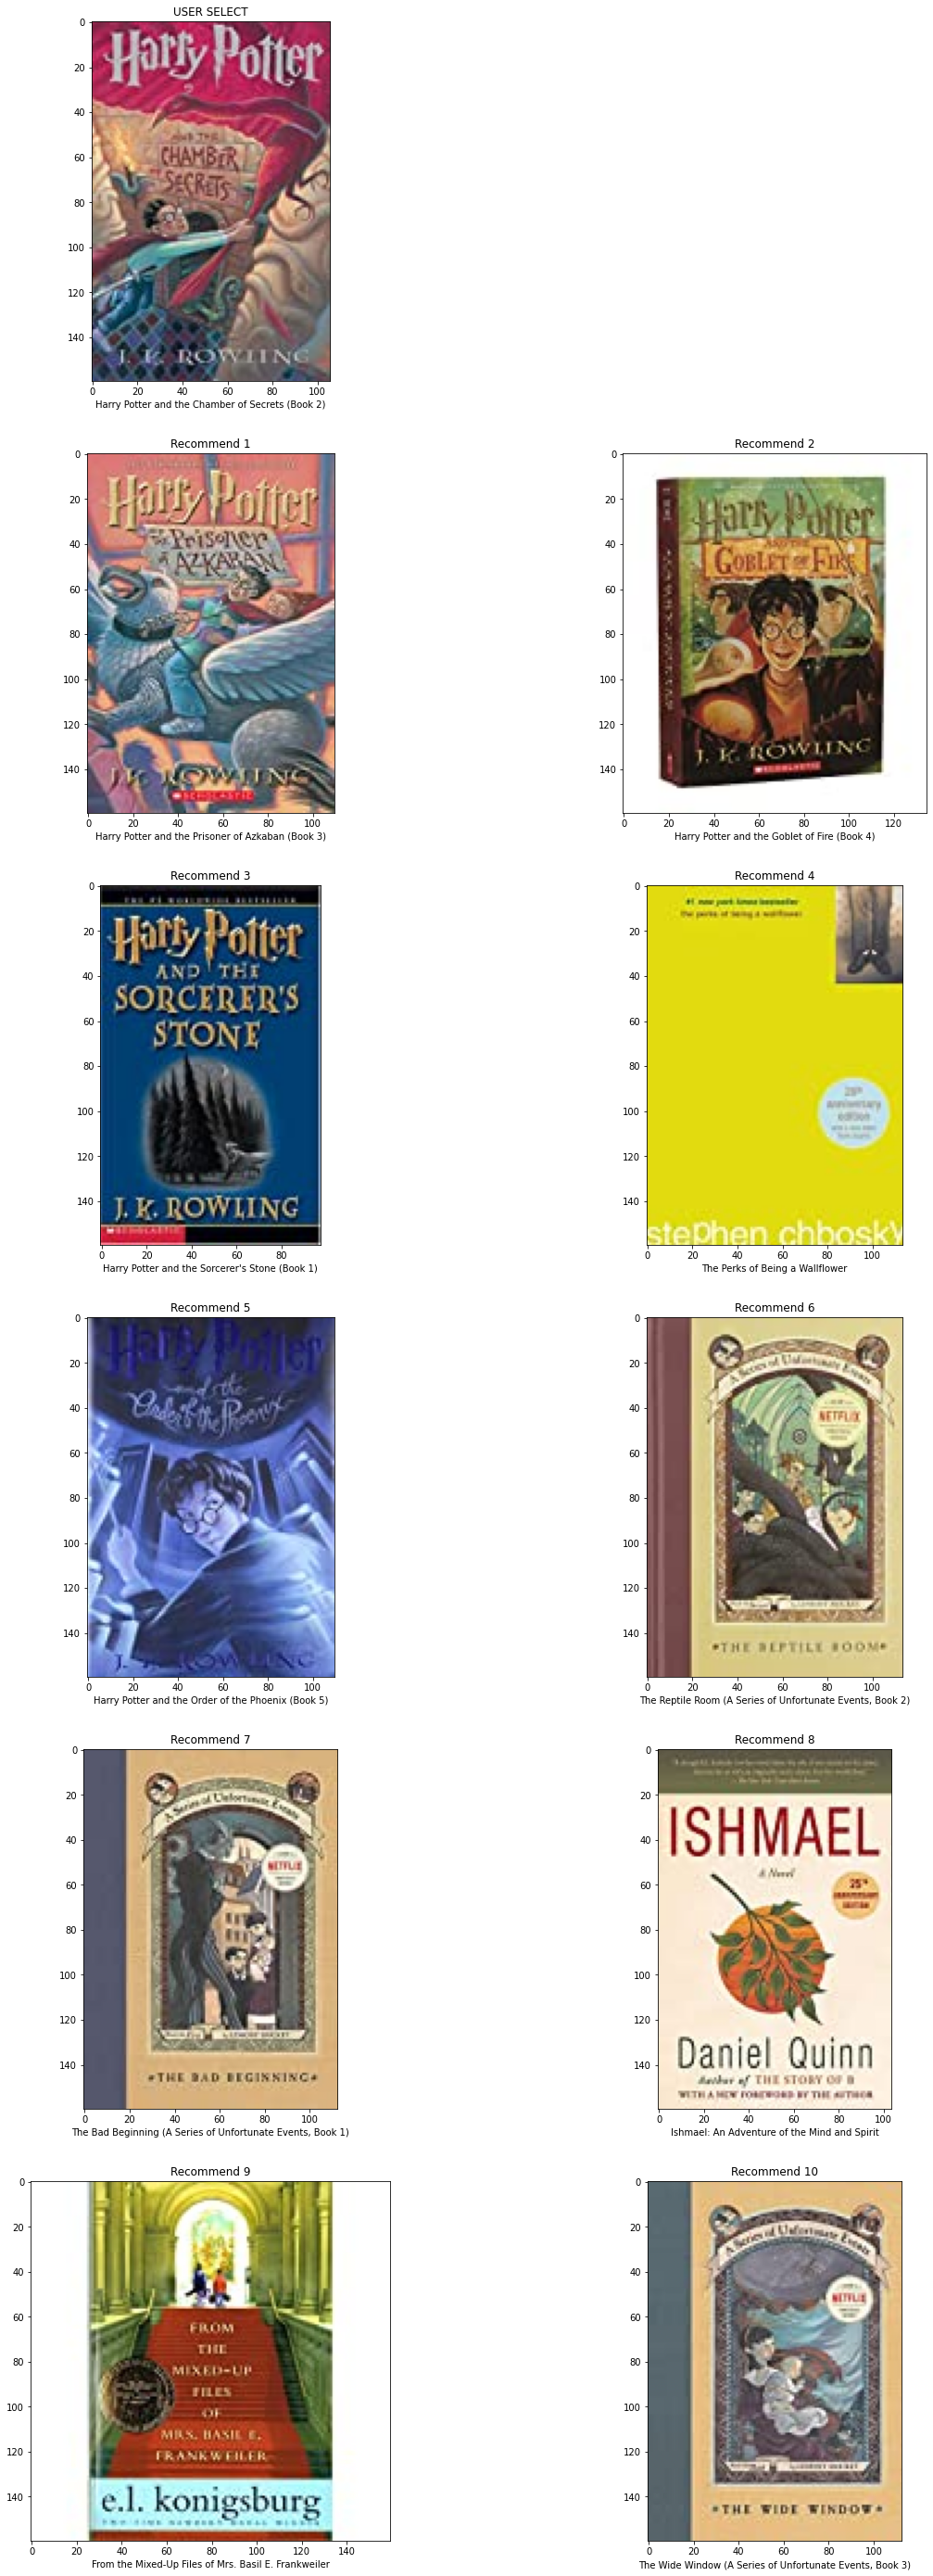

In [38]:
result = book_recommend(model, title='Harry Potter and the Chamber of Secrets (Book 2)', show=True)